# DAT257x: Reinforcement Learning Explained

## Lab 7: Policy Gradient

### Exercise 7.3: Actor Critic

## Objectives
* Implement A3C-like N-step updating: $Q(s_t,a_t) = E[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^n V(s_{t+n})]$
* Play around with different values of $n$. How does the value of $n$ affect the variance and performance of the algorithm?

## Success Criterion
The variance with n-step updates should be even smaller than that of Baselined Reinforce. A correct implementation will not solve the Cartpole domain faster or more frequently, but it should do so with less variance. 

In [1]:
import cntk as C
from cntk.layers import Sequential, Dense
from cntk.logging import ProgressPrinter
import numpy as np

import sys
if "../" not in sys.path:
    sys.path.append("../") 
    
import gym
from lib.running_variance import RunningVariance
from lib import plotting

np.random.seed(123)
C.cntk_py.set_fixed_random_seed(123)
C.cntk_py.force_deterministic_algorithms()

env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0] # Dimension of state space
action_count = env.action_space.n # Number of actions
hidden_size = 128 # Number of hidden units
update_frequency = 20

# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable(state_dim, np.float32, name="obs")
W1 = C.parameter(shape=(state_dim, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)
W2 = C.parameter(shape=(hidden_size, action_count), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=action_count, name="b2")
layer2 = C.times(layer1, W2) + b2
output = C.sigmoid(layer2, name="output")

# Label will tell the network what action it should have taken.
label = C.sequence.input_variable(1, np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")
# PG Loss 
loss = -C.reduce_mean(C.log(C.square(label - output) + 1e-4) * return_weight, axis=0, name='loss')

# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

# Define the critic network
critic = Sequential([
    Dense(128, activation=C.relu, init=C.glorot_uniform()),
    Dense(1, activation=None, init=C.glorot_uniform(scale=.01))
])(observations)

# Define target and Squared Error Loss Function, adam optimizier, and trainer for the Critic.
critic_target = C.sequence.input_variable(1, np.float32, name="target")
critic_loss = C.squared_error(critic, critic_target)
critic_lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
critic_optimizer = C.adam(critic.parameters, critic_lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)
critic_trainer = C.Trainer(critic, (critic_loss, None), critic_optimizer)

def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

Now you need to implement the function that computes n-step update targets:

In [2]:
# TODO: Create a function that returns an array of n-step targets, one for each timestep:
# target[t] = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^n V(s_{t+n})
# Where r_t is given by episode reward (epr) and V(s_n) is given by the baselines.
def compute_n_step_targets(epr, baselines, gamma=0.999, n=15):
    """ Computes a n_step target value. """
    n_step_targets = np.zeros_like(epr)

    ## Code here
    
    return n_step_targets

The main loop is the same and should not need modification except for trying different values of $n$.

In [3]:
running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))

for episode_number in range(max_number_of_episodes):
    states, rewards, labels = [],[],[]
    done = False
    observation = env.reset()
    t = 1
    while not done:
        state = np.reshape(observation, [1, state_dim]).astype(np.float32)
        states.append(state)

        # Run the policy network and get an action to take.
        prob = output.eval(arguments={observations: state})[0][0][0]
        # Sample from the bernoulli output distribution to get a discrete action
        action = 1 if np.random.uniform() < prob else 0

        # Pseudo labels to encourage the network to increase
        # the probability of the chosen action. This label will be used
        # in the loss function above.
        y = 1 if action == 0 else 0  # a "fake label"
        labels.append(y)

        # step the environment and get new measurements
        observation, reward, done, _ = env.step(action)
        reward_sum += float(reward)

        # Record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(float(reward))
        
        stats.episode_rewards[episode_number] += reward
        stats.episode_lengths[episode_number] = t
        t += 1

    # Stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(states)
    epl = np.vstack(labels).astype(np.float32)
    epr = np.vstack(rewards).astype(np.float32)

    # Compute the discounted reward backwards through time.
    discounted_epr = discount_rewards(epr)

    # Train the critic to predict the discounted reward from the observation
    critic_trainer.train_minibatch({observations: epx, critic_target: discounted_epr})
    baseline = critic.eval({observations: epx})
    
    # Compute n-step targets
    n_step_targets = compute_n_step_targets(epr, baseline[0])

    # Compute the baselined returns: A = n_step_targets - b(s). Weight the gradients by this value.
    baselined_returns = n_step_targets - baseline
    
    # Keep a running estimate over the variance of of the discounted rewards
    for r in baselined_returns:
        running_variance.add(r[0,0])

    # Forward pass
    arguments = {observations: epx, label: epl, return_weight: baselined_returns}
    state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                                      keep_for_backward=loss.outputs)

    # Backward pass
    root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
    vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

    for var, grad in vargrads_map.items():
        gradBuffer[var.name] += grad

    # Only update every 20 episodes to reduce noise
    if episode_number % update_frequency == 0:
        grads = {W1: gradBuffer['W1'].astype(np.float32),
                 W2: gradBuffer['W2'].astype(np.float32)}
        updated = optimizer.update(grads, update_frequency)

        # reset the gradBuffer
        gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                          for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

        print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, reward_sum / update_frequency, running_variance.get_variance()))

        reward_sum = 0
        
    stats.episode_running_variance[episode_number] = running_variance.get_variance()

Episode: 0. Average reward for episode 1.450000. Variance -0.000000


../lib/running_variance.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return self.s_k / (self.k - 1)


Episode: 20. Average reward for episode 16.300000. Variance 17.364418
Episode: 40. Average reward for episode 11.600000. Variance 16.602448
Episode: 60. Average reward for episode 10.550000. Variance 17.155964
Episode: 80. Average reward for episode 9.500000. Variance 12.936291
Episode: 100. Average reward for episode 9.600000. Variance 11.074494
Episode: 120. Average reward for episode 9.550000. Variance 9.664771
Episode: 140. Average reward for episode 9.200000. Variance 8.468610
Episode: 160. Average reward for episode 9.400000. Variance 7.780062
Episode: 180. Average reward for episode 8.950000. Variance 7.483322
Episode: 200. Average reward for episode 9.400000. Variance 6.838455
Episode: 220. Average reward for episode 9.350000. Variance 6.222481
Episode: 240. Average reward for episode 9.450000. Variance 5.714885
Episode: 260. Average reward for episode 9.400000. Variance 5.325135
Episode: 280. Average reward for episode 9.250000. Variance 4.958329
Episode: 300. Average reward f

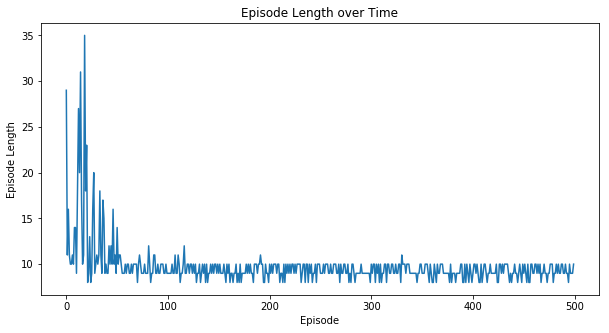

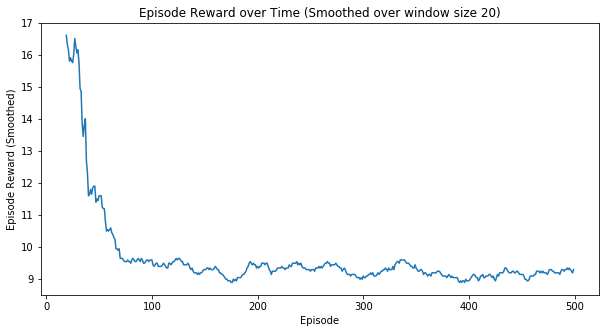

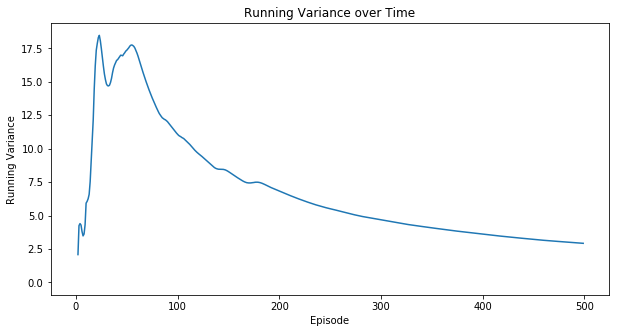

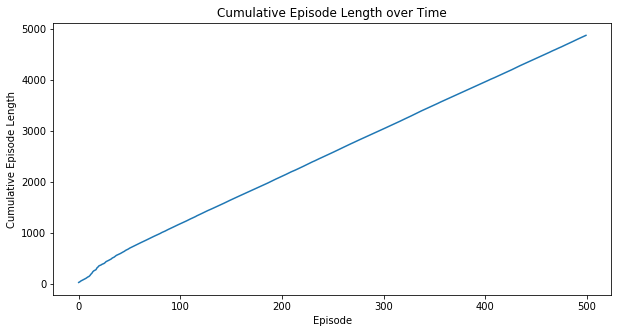

(<matplotlib.figure.Figure at 0x7f4ea4984860>,
 <matplotlib.figure.Figure at 0x7f4ea0b5e278>)

In [4]:
plotting.plot_pgresults(stats)